Build a model to forecast the demand (Passengers Traffic) in Airplanes. The data is classified in date/time and the passengers travelling per month

In [7]:
#Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [9]:
#Packages
!pip install pmdarima
import itertools
from sklearn.metrics import *
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# We are going to use automated tools for the order of AR and MA

In [10]:
#Mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df = pd.read_csv("/content/drive/MyDrive/AirPassengers.xls")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
df.shape

(144, 2)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Here, we need to convert this month column into a date-time dtype

In [14]:
df["Month"]=pd.to_datetime(df["Month"],infer_datetime_format=True)

In [15]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [16]:
df=df.set_index("Month")

Visualize

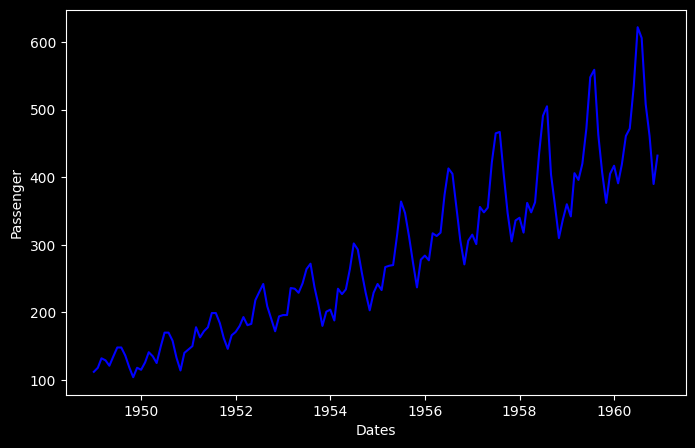

In [17]:
plt.figure(figsize=(8,5))
plt.plot(df,color="blue")
plt.xlabel("Dates")
plt.ylabel("Passenger")
plt.show()

Step 3 - Check for stationarity
Mean and the variance of the data should be constant throughout the time period

Rolling Statistics

In [18]:
rolling_mean=df.rolling(window=12).mean()
rolling_std=df.rolling(window=12).std()

Visualize

[]

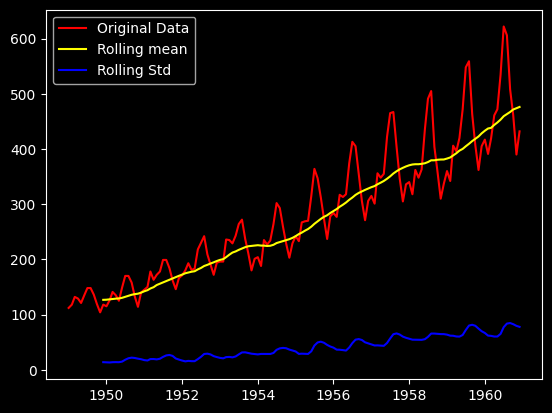

In [19]:
original_data = plt.plot(df, color = "red", label = "Original Data")
mean_data = plt.plot(rolling_mean, color = "yellow", label = "Rolling mean")
std_data = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
plt.legend()
plt.plot()

In [20]:
from statsmodels.tsa.stattools import adfuller

results=adfuller(df)


In [21]:
print(f"P-Value:{results[1]}")

P-Value:0.991880243437641


In [22]:
if results[1]>0.05:
    print("Not Stationarity")
else:
    print("Stationarity")

Not Stationarity


Helper Function

In [23]:
def helper_check(data):
    # Rolling mean for the 1 year timeframe
    rolling_mean=data.rolling(window=12).mean()
    #rolling std for the 1 year timeframe
    rolling_std=data.rolling(window=12).std()

    original_data = plt.plot(df, color = "red", label = "Original Data")
    mean_data = plt.plot(rolling_mean, color = "yellow", label = "Rolling mean")
    std_data = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
    plt.legend()
    plt.plot()

    results=adfuller(data)
    print(f"P-value:{results[1]}")

    if results[1] > 0.05:
        return"The data is not stationary"
    else:
        return "The data is stationary"


In [24]:
#Step 4 - Achieving the stationarity
#Transformation: Using this we can scale the values, and this will actually help us in making the variance constant
#Differencing / Shift

Log Transformation

In [25]:
df_log=np.log(df)

P-value:0.4223667747703874


'The data is not stationary'

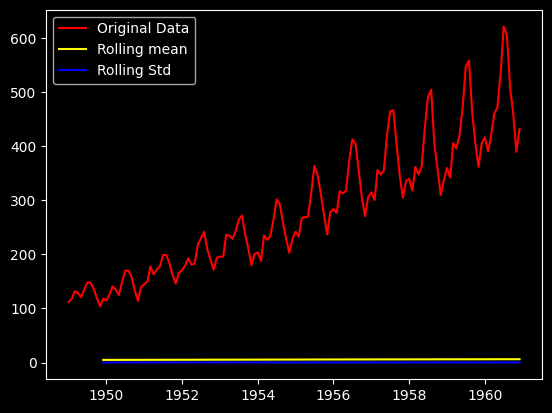

In [26]:
#Check for the stationarity
helper_check(df_log)

In [27]:
#Differencing
#It's just taking the difference from the previous timestamp

In [28]:
df_log_diff1 = df_log.diff().dropna()

P-value:0.07112054815086184


'The data is not stationary'

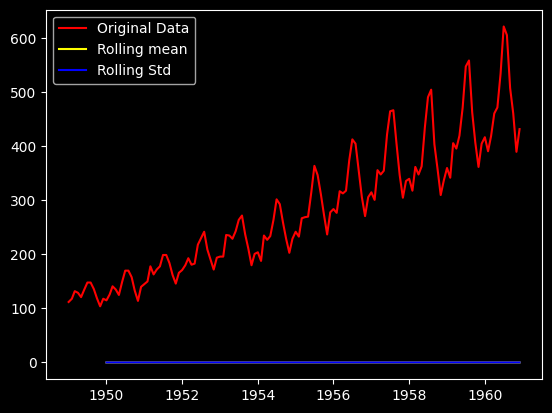

In [29]:
helper_check(df_log_diff1)

In [30]:
df_log_diff2 = df_log.diff().diff().dropna()

In [31]:
df_log_diff2

,#Passengers
Month,
1949-03-01,0.059932
1949-04-01,-0.135107
1949-05-01,-0.041032
1949-06-01,0.173506
1949-07-01,-0.017547
...,...
1960-08-01,-0.176733
1960-09-01,-0.150338
1960-10-01,0.079315


P-value:7.419304549376186e-13


'The data is stationary'

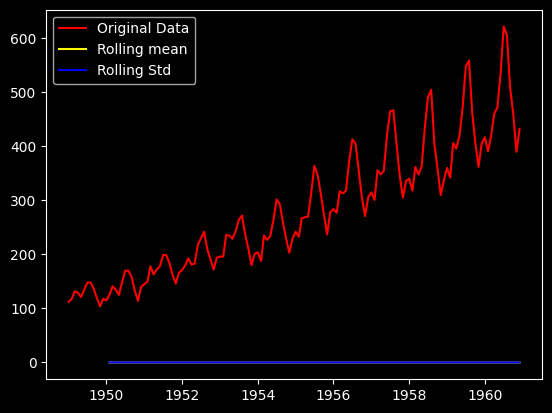

In [32]:
helper_check(df_log_diff2)

Step-5: Discovering order of Time Series

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

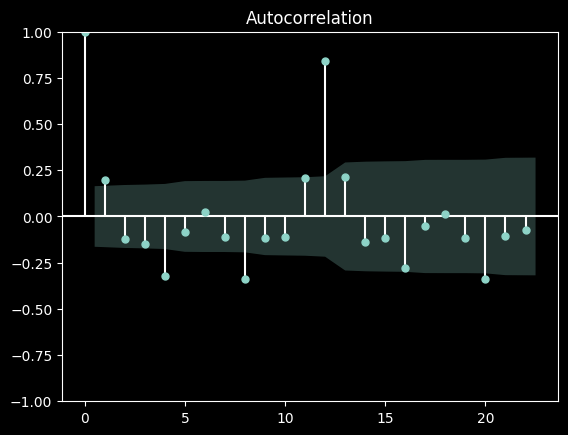

In [34]:
plot_acf(df_log_diff1)
plt.show()
plt.close()

Assuming/ Assumption: Order of ARIMA: (4, 0, 4)

In [35]:
#In summary, an ARIMA(4, 0, 4) model:

#Uses the past four values of the series to predict the current value (AR part).
#Does not apply any differencing, meaning it assumes the series is stationary (I part).
#Incorporates the last four forecast errors into the prediction (MA part).

Step 6 - Model Building

In [36]:
model=ARIMA(df_log_diff1,order=(4,0,4))

In [37]:
results=model.fit()

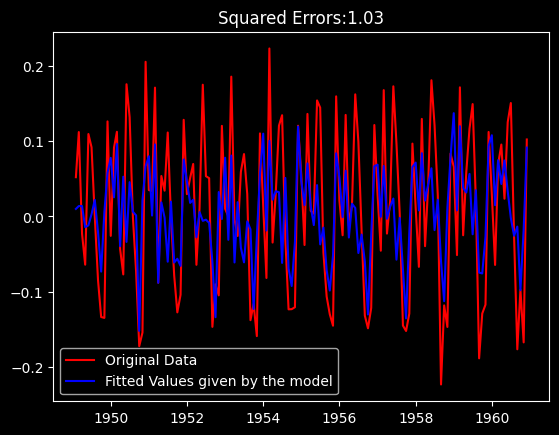

In [38]:
plt.plot(df_log_diff1,label="Original Data",color="red")
plt.plot(results.fittedvalues,label = "Fitted Values given by the model", color = "blue")
plt.title("Squared Errors:%.2f"%sum((results.fittedvalues - df_log_diff1["#Passengers"])**2))

plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2915.873, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3049.597, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2954.975, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2947.028, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3047.612, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2940.108, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2915.651, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2986.348, Time=1.12 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2915.275, Time=1.30 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2918.411, Time=2.13 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=2925.080, Time=3.96 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=2911.330, Time=1.32 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2911.555, Time=1.74 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=2914.196, Time=1.30 sec
 ARIMA(2,1,1)(1,0,1

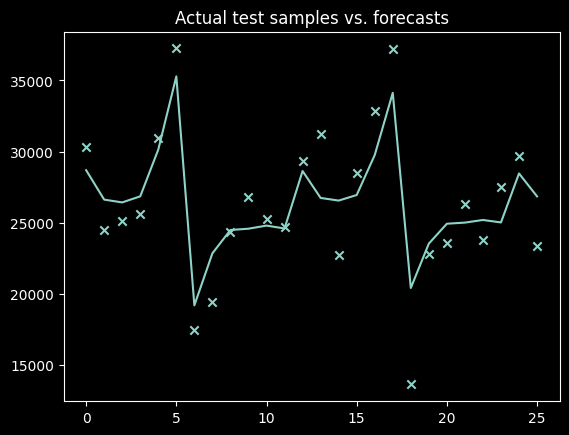

In [39]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

data=pm.datasets.load_wineind()
train,test=model_selection.train_test_split(data,train_size=150)

arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [40]:
pred=results.predict(1,143+60)

[]

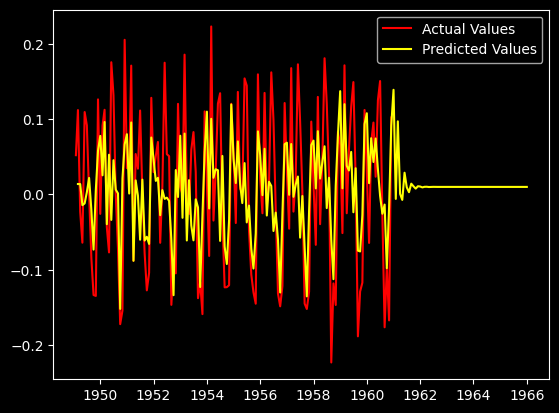

In [41]:
plt.plot(df_log_diff1, color = "red", label = "Actual Values")
plt.plot(pred, color = "yellow", label = "Predicted Values")
plt.legend()
plt.plot()

Step 8 - SARIMA

In [42]:
model=SARIMAX(df_log_diff1,order=(4,0,3),seasonal_order = (4, 0, 3, 12))

In [43]:
results=model.fit()

Forecast

In [44]:
forecast=results.forecast(steps=60)

[]

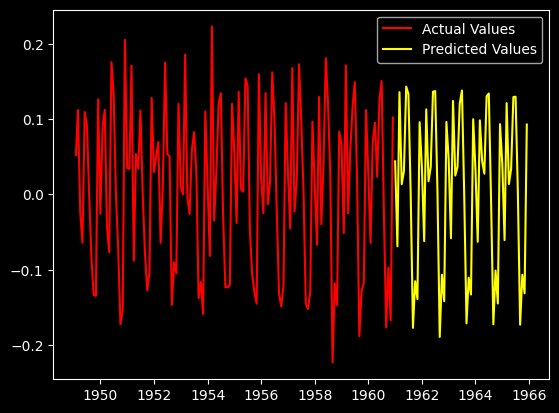

In [45]:
plt.plot(df_log_diff1, color = "red", label = "Actual Values")
plt.plot(forecast, color = "yellow", label = "Predicted Values")
plt.legend()
plt.plot()